# Build Agent

In [2]:
import os
import logging
from hydra.utils import instantiate
from hydra import initialize, compose
from omegaconf import OmegaConf
from navsim.agents.abstract_agent import AbstractAgent

os.environ["TRANSFORMERS_CACHE"] = "/n/fs/pci-sharedt/mb9385/hf_cache"

config_path = "navsim/planning/script/config/common/agent"
config_name = "rap_agent"

logger = logging.getLogger(__name__)

logger.info("Initializing Hydra and composing config")
# Use hydra.initialize + compose to load the YAML config into `cfg`
with initialize(config_path=config_path, job_name="run"):
    cfg = compose(config_name=config_name)

# Optional: log the composed config for debugging
logger.info("Composed config:")
cfg.config.trajectory_sampling.time_horizon = 5 # to match weights shape and description in paper 
logger.info(OmegaConf.to_yaml(cfg))

logger.info("Building Agent")
agent: AbstractAgent = instantiate(cfg)

# from navsim.planning.training.agent_lightning_module import AgentLightningModule
# logger.info("Building Lightning Module")
# lightning_module = AgentLightningModule(
#     agent=agent,
# )

/tmp/ipykernel_2359735/2642994842.py:17: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path=config_path, job_name="run"):
/n/fs/pci-sharedt/mb9385/miniconda3/envs/gpudrive-gen-rap/lib/python3.11/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
/n/fs/pci-sharedt/mb9385/workspace/priv-gpudrive/e2e_models/RAP/navsim/agents/rap_dino/bevformer/multi_scale_deformable_attn_function.py:12: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
/n/fs/pci-sharedt/mb9385/workspace/priv-gpudrive/e2e_models/RAP/navs

Missing keys when loading pretrained weights: ['_rap_model.domain_classifier.classifier.0.weight', '_rap_model.domain_classifier.classifier.0.bias', '_rap_model.domain_classifier.classifier.2.weight', '_rap_model.domain_classifier.classifier.2.bias', '_rap_model.domain_classifier.classifier.4.weight', '_rap_model.domain_classifier.classifier.4.bias']
Initialized from pretrained model in 9.9 seconds


# Compute trajectory on logs and visualize

Forward took 1.1 seconds


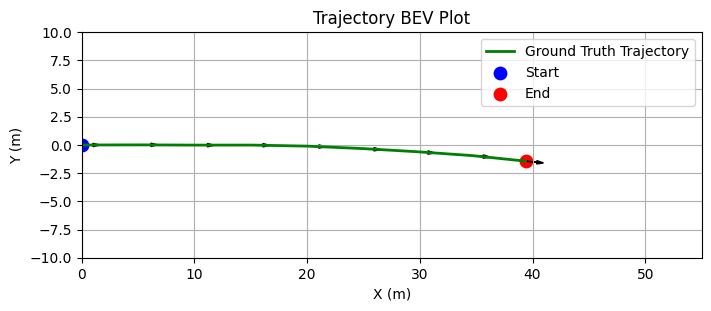

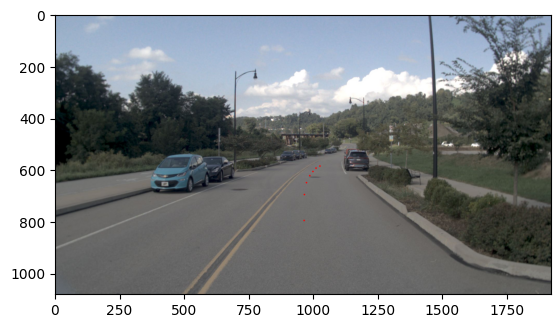

/n/fs/pci-sharedt/mb9385/workspace/priv-gpudrive/e2e_models/RAP/navsim/agents/rap_dino/bevformer/grid_mask.py:121: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.from_numpy(mask).to(x.dtype).to(x.device)


Forward took 0.7 seconds


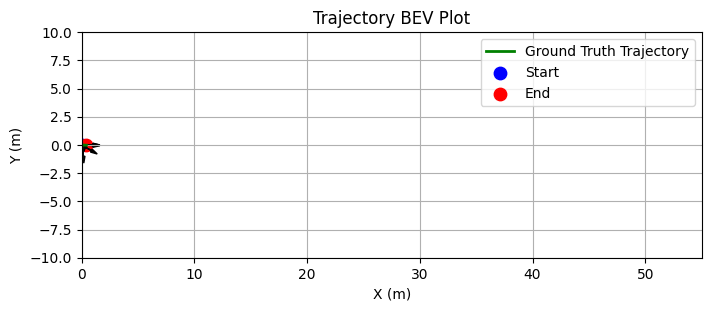

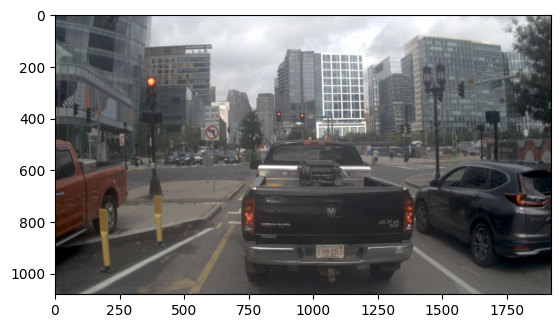


Forward took 0.5 seconds


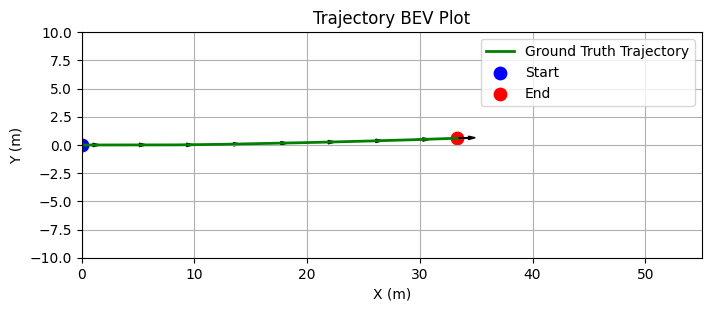

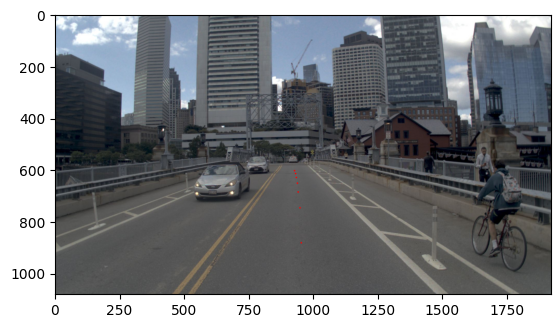


Forward took 0.7 seconds


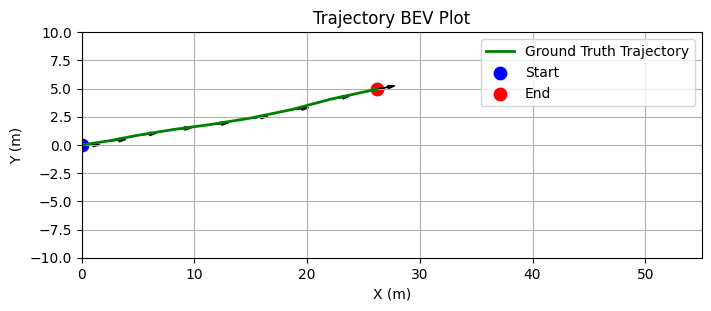

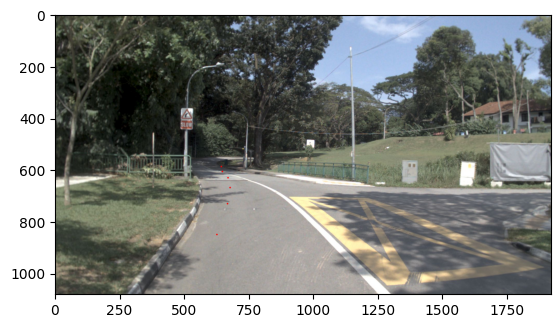

In [3]:
from glob import glob
from pathlib import Path
import pickle
from time import time
from typing import Dict

import torch

from navsim.common.dataclasses import AgentInput, Trajectory
import numpy as np

from navsim.visualization.camera import _transform_pcs_to_images
from navsim.common.enums import LidarIndex
from navsim.common.dataclasses import Trajectory

import cv2
import matplotlib.pyplot as plt

device = "cuda:0"
agent._rap_model.to(device)

def run_planner(agent: AbstractAgent, log_pickle_path: str):
    """Run the planner on a single log pickle file."""
    scene_dict_list = pickle.load(open(log_pickle_path, "rb"))
    agent_input = AgentInput.from_scene_dict_list(
        scene_dict_list,
        sensor_blobs_path=Path("/n/fs/pci-sharedt/ar3156/diffusion_drive/DiffusionDrive/dataset/sensor_blobs/test"),
        num_history_frames=4,
        sensor_config=agent.get_sensor_config(),
    )
    features: Dict[str, torch.Tensor] = {}

    # Content is mainly copied from:
    # trajectory = agent.compute_trajectory(agent_input)

    features: Dict[str, torch.Tensor] = {}
    # build features
    for builder in agent.get_feature_builders():
        features.update(builder.compute_features(agent_input))

    # add batch dimension
    features = {k: v.unsqueeze(0).to(device) for k, v in features.items()}

    start = time()
    with torch.no_grad():
        predictions = agent.forward(features)
        poses = predictions["trajectory"].squeeze(0).cpu().numpy()[:8]
    print("Forward took {:.1f} seconds".format(time() - start))

    # extract trajectory
    trajectory = Trajectory(poses)
    return agent_input, trajectory



def visualize_trajectory_bev(trajectory: Trajectory, agent_input: AgentInput):
    """Visualize trajectory in BEV plot."""
    # Extract x, y, and heading (yaw)
    x = trajectory.poses[:, 0]
    y = trajectory.poses[:, 1]
    yaw = trajectory.poses[:, 2]
    # Add starting point at origin
    x = np.concatenate(([0.0], x))
    y = np.concatenate(([0.0], y))
    yaw = np.concatenate(([0.0], yaw))

    # Simple BEV plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.set_title("Trajectory BEV Plot")

    # Plot trajectory as a line
    ax.plot(x, y, 'g-', linewidth=2, label='Ground Truth Trajectory')

    # Mark start and end
    ax.scatter(x[0], y[0], color='blue', s=80, label='Start')
    ax.scatter(x[-1], y[-1], color='red', s=80, label='End')
    ax.set_ylim(-10, 10)        # e.g. shows the band from –10 m to 0 m in y
    ax.set_xlim(0, 55)         # optional: adjust x-view range

    # Optionally: draw vehicle heading arrows
    for xi, yi, psi in zip(x, y, yaw):
        ax.arrow(xi, yi, np.cos(psi), np.sin(psi), head_width=0.3, head_length=0.6, fc='black', ec='black')

    ax.grid(True)
    ax.legend()
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.show()

def draw_trajectory_on_image(
        image: torch.Tensor,
        trajectory: Trajectory,
        color: tuple,
        cam2lidar: np.ndarray,
        cam2img: np.ndarray = None
    ):
    """Draw trajectory on image using sensor setup to project 3D trajectory points to image coordinates.
    
    Args:
        image: Input image to draw on
        trajectory: Array of trajectory points in world/lidar coordinates (N, 2) or (N, 3)
        color: RGB color tuple for drawing
        cam2lidar: 4x4 transformation matrix from camera to lidar coordinates
        cam2img: 3x3 camera intrinsic matrix (optional, default identity)
    """
    if image.dtype == torch.float32 or image.dtype == torch.float64:
        img = np.uint8(np.array(image) * 255.0)
    else:
        assert image.dtype == np.uint8
        img = image
    H, W = img.shape[:2]
    
    # Convert trajectory to proper format for transformation
    traj_points = np.array(trajectory.poses[:, :2], dtype=np.float32)
    if traj_points.shape[1] == 2:
        # Add z=0 for 2D trajectory points
        z_values = np.zeros((traj_points.shape[0], 1), dtype=np.float32)
        traj_points = np.concatenate([traj_points, z_values], axis=1)
    
    # Create fake lidar point cloud format expected by _transform_pcs_to_images
    # LidarIndex expects (6, N) format: (x, y, z, intensity, ring, lidar_id)
    fake_lidar_pc = np.zeros((6, traj_points.shape[0]), dtype=np.float32)
    fake_lidar_pc[LidarIndex.X, :] = traj_points[:, 0]
    fake_lidar_pc[LidarIndex.Y, :] = traj_points[:, 1] 
    fake_lidar_pc[LidarIndex.Z, :] = traj_points[:, 2]
    
    # Transform trajectory points to image coordinates
    proj_points, in_fov_mask = _transform_pcs_to_images(
        lidar_pc=fake_lidar_pc,
        sensor2lidar_rotation=cam2lidar[:3, :3],  # sensor2lidar_rotation
        sensor2lidar_translation=cam2lidar[:3, 3],   # sensor2lidar_translation
        intrinsic=cam2img,
        img_shape=(H, W)
    )
    
    # Draw trajectory points that are in field of view
    for _, (x, y) in enumerate(proj_points[in_fov_mask]):
        cv2.circle(img, (int(x), int(y)), radius=3, color=color, thickness=-1)
            
    return np.uint8(img)


log_pickle_paths = glob("/n/fs/pci-sharedt/ar3156/diffusion_drive/DiffusionDrive/dataset/navsim_logs/test/*")
for idx, log_pickle_path in enumerate(log_pickle_paths):
    agent_input, trajectory = run_planner(agent, log_pickle_path)
    visualize_trajectory_bev(trajectory, agent_input)
    # plt.imshow(agent_input.cameras[3].cam_f0.image)
    # plt.show()
    cam2lidar = np.eye(4)
    cam2lidar[:3, :3] = agent_input.cameras[3].cam_f0.sensor2lidar_rotation
    cam2lidar[:3, 3] = agent_input.cameras[3].cam_f0.sensor2lidar_translation
    cam2img = agent_input.cameras[3].cam_f0.intrinsics
    # TODO: Distortion not considered for now.
    overlay = draw_trajectory_on_image(
        image=agent_input.cameras[3].cam_f0.image,
        trajectory=trajectory,
        color=(255, 0, 0),
        cam2lidar=cam2lidar,
        cam2img=cam2img,
    )
    plt.imshow(overlay)
    plt.show()
    if idx >= 3:
        break
    print("")

In [1]:
import torch

x = torch.load("/n/fs/pci-sharedt/mb9385/workspace/priv-gpudrive/e2e_models/RAP/agent_input_2.pth")

/tmp/ipykernel_2352584/2403394046.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load("/n/fs/pci-sharedt/mb9385/workspace/priv-gpudrive/e2e_models/RAP/agent_i

In [4]:
print("")

KeyboardInterrupt: 